# Plots for pr - all models

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import datetime
import gcsfs
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import time
import xarray as xr
import zarr

### Imput files

In [2]:
path = '/nird/home/julnavda/CMIP6/'

# UKESM
UK_filename_base = path + 'ssp370SST/pr/pr_Amon_UKESM1-0-LL_ssp370SST_r1i1p1f2_gn_201501-209912.nc'
UK_filename_signal = path + 'ssp370SST-lowBC/pr/pr_Amon_UKESM1-0-LL_ssp370SST-lowBC_r1i1p1f2_gn_201501-209912.nc'

UKESM_base = xr.open_dataset(UK_filename_base)
UKESM_signal = xr.open_dataset(UK_filename_signal)

# MIROC6
MIR_filename_base = path + 'ssp370SST/pr/pr_Amon_MIROC6_ssp370SST_r1i1p1f1_gn_201501-209912.nc'
MIR_filename_signal = path + 'ssp370SST-lowBC/pr/pr_Amon_MIROC6_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc'

MIROC_base = xr.open_dataset(MIR_filename_base)
MIROC_signal = xr.open_dataset(MIR_filename_signal)

# MPI-ESM
MPI_filename_base = path + 'ssp370SST/pr/pr_Amon_MPI-ESM-1-2-HAM_ssp370SST_r1i1p1f1_gn_201501-205512.nc'
MPI_filename_signal = path + 'ssp370SST-lowBC/pr/pr_Amon_MPI-ESM-1-2-HAM_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc'

MPI_ESM_base = xr.open_dataset(MPI_filename_base)
MPI_ESM_signal = xr.open_dataset(MPI_filename_signal)

In [3]:
UKESM_base

<xarray.Dataset>
Dimensions:    (time: 1020, bnds: 2, lon: 192, lat: 144)
Coordinates:
  * time       (time) object 2015-01-16 00:00:00 ... 2099-12-16 00:00:00
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.1.1 (https://mpi...
    source:                 UKESM1.0-LL (2018): \naerosol: UKCA-GLOMAP-mode\n...
    institution:            Natural Environment Research Council, STFC-RAL, H...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            AerChemMIP
    branch_method:          standard
    ...                     ...
    variable_name:          pr
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Natural Environm...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/708e5677-ca50-4744-8341-1fbdaf8867f8
    CDO:                    Climate Data Operators version 2.1.1 (https://mpi...

### Convert units

In [4]:
def convert_to_mm_day(ds):
    ds['pr'] = ds['pr'] * 86400
    ds['pr'].attrs.update({'units': 'mm/day',
    'long_name': 'Precipitation',
    'standard_name': 'precipitation_flux_in_mm_per_day'})  # Update attributes
    return ds

MIROC_base, MIROC_signal = convert_to_mm_day(MIROC_base), convert_to_mm_day(MIROC_signal)
MPI_ESM_base, MPI_ESM_signal = convert_to_mm_day(MPI_ESM_base), convert_to_mm_day(MPI_ESM_signal)
UKESM_base, UKESM_signal = convert_to_mm_day(UKESM_base), convert_to_mm_day(UKESM_signal)

In [5]:
UKESM_base

<xarray.Dataset>
Dimensions:    (time: 1020, bnds: 2, lon: 192, lat: 144)
Coordinates:
  * time       (time) object 2015-01-16 00:00:00 ... 2099-12-16 00:00:00
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    pr         (time, lat, lon) float64 0.1673 0.166 0.1571 ... 2.118 2.092
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.1.1 (https://mpi...
    source:                 UKESM1.0-LL (2018): \naerosol: UKCA-GLOMAP-mode\n...
    institution:            Natural Environment Research Council, STFC-RAL, H...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            AerChemMIP
    branch_method:          standard
    ...                     ...
    variable_name:          pr
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Natural Environm...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/708e5677-ca50-4744-8341-1fbdaf8867f8
    CDO:                    Climate Data Operators version 2.1.1 (https://mpi...

### Define functions

In [6]:
def calculate_anomaly(start_year, end_year, dataset1, dataset2):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"  
    mean1 = dataset1.sel(time=slice(start_date, end_date)).mean(dim='time')
    mean2 = dataset2.sel(time=slice(start_date, end_date)).mean(dim='time')
    return mean2['pr'] - mean1['pr']

In [7]:
def calculate_annual_means(dataset, start_year, end_year):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"
    return dataset.sel(time=slice(start_date, end_date)).resample(time='A').mean(dim='time')

In [8]:
def calculate_seasonal_anomaly_mm(start_year, end_year, dataset1, dataset2, season):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"  

    # Filter datasets by season
    ds1_seasonal = dataset1.sel(time=slice(start_date, end_date))
    ds1_seasonal = ds1_seasonal.sel(time=ds1_seasonal['time'].dt.season == season)

    ds2_seasonal = dataset2.sel(time=slice(start_date, end_date))
    ds2_seasonal = ds2_seasonal.sel(time=ds2_seasonal['time'].dt.season == season)

    # Calculate means for the specific season
    mean1 = ds1_seasonal.mean(dim='time')
    mean2 = ds2_seasonal.mean(dim='time')

    return mean2['pr'] - mean1['pr']

In [9]:
def calculate_seasonal_anomaly_pr(start_year, end_year, dataset1, dataset2, season):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"  

    # Filter datasets by season
    ds1_seasonal = dataset1.sel(time=slice(start_date, end_date))
    ds1_seasonal = ds1_seasonal.sel(time=ds1_seasonal['time'].dt.season == season)

    ds2_seasonal = dataset2.sel(time=slice(start_date, end_date))
    ds2_seasonal = ds2_seasonal.sel(time=ds2_seasonal['time'].dt.season == season)

    # Calculate means for the specific season
    mean1 = ds1_seasonal.mean(dim='time')
    mean2 = ds2_seasonal.mean(dim='time')
    
    anomaly = mean2['pr'] - mean1['pr']
    
    return (anomaly / mean1['pr']) * 100  # Calculate percentage change

### Colorscale

In [10]:
# Define a custom colorscale thats standard for precipitation visualization
colorscale = [
    '#543005', '#7f4909', '#a76a1d', '#c99545', '#e1c582', 
    '#f2e2b8', '#f6f0e2', '#e4f1ef', '#bce6e0', '#86cfc4', 
    '#4ea79e', '#218078', '#015c53', '#003c30'
]

# Create the custom colormap
cmap_custom = LinearSegmentedColormap.from_list("custom", colorscale, N=256)

In [11]:
norm = mcolors.TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)
norm_percent = mcolors.TwoSlopeNorm(vmin=-50, vcenter= 0, vmax=50)

### Intervals

In [12]:
UKESM_intervals = [(2015, 2034), (2035,2054), (2055, 2074), (2075, 2094)]
MIROC6_intervals = [(2015, 2034), (2035,2054)]
MPI_ESM_intervals = [(2015, 2034), (2035,2054)]

In [13]:
UKESM_anomalies_mm = [calculate_anomaly(start, end, UKESM_base, UKESM_signal) for start, end in UKESM_intervals]
MIROC6_anomalies_mm = [calculate_anomaly(start, end, MIROC_base, MIROC_signal) for start, end in MIROC6_intervals]
MPI_ESM_anomalies_mm = [calculate_anomaly(start, end, MPI_ESM_base, MPI_ESM_signal) for start, end in MPI_ESM_intervals]

# Global

### mm/day

/tmp/ipykernel_1691875/3699010311.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.13, 0, 0.9, 0.95])


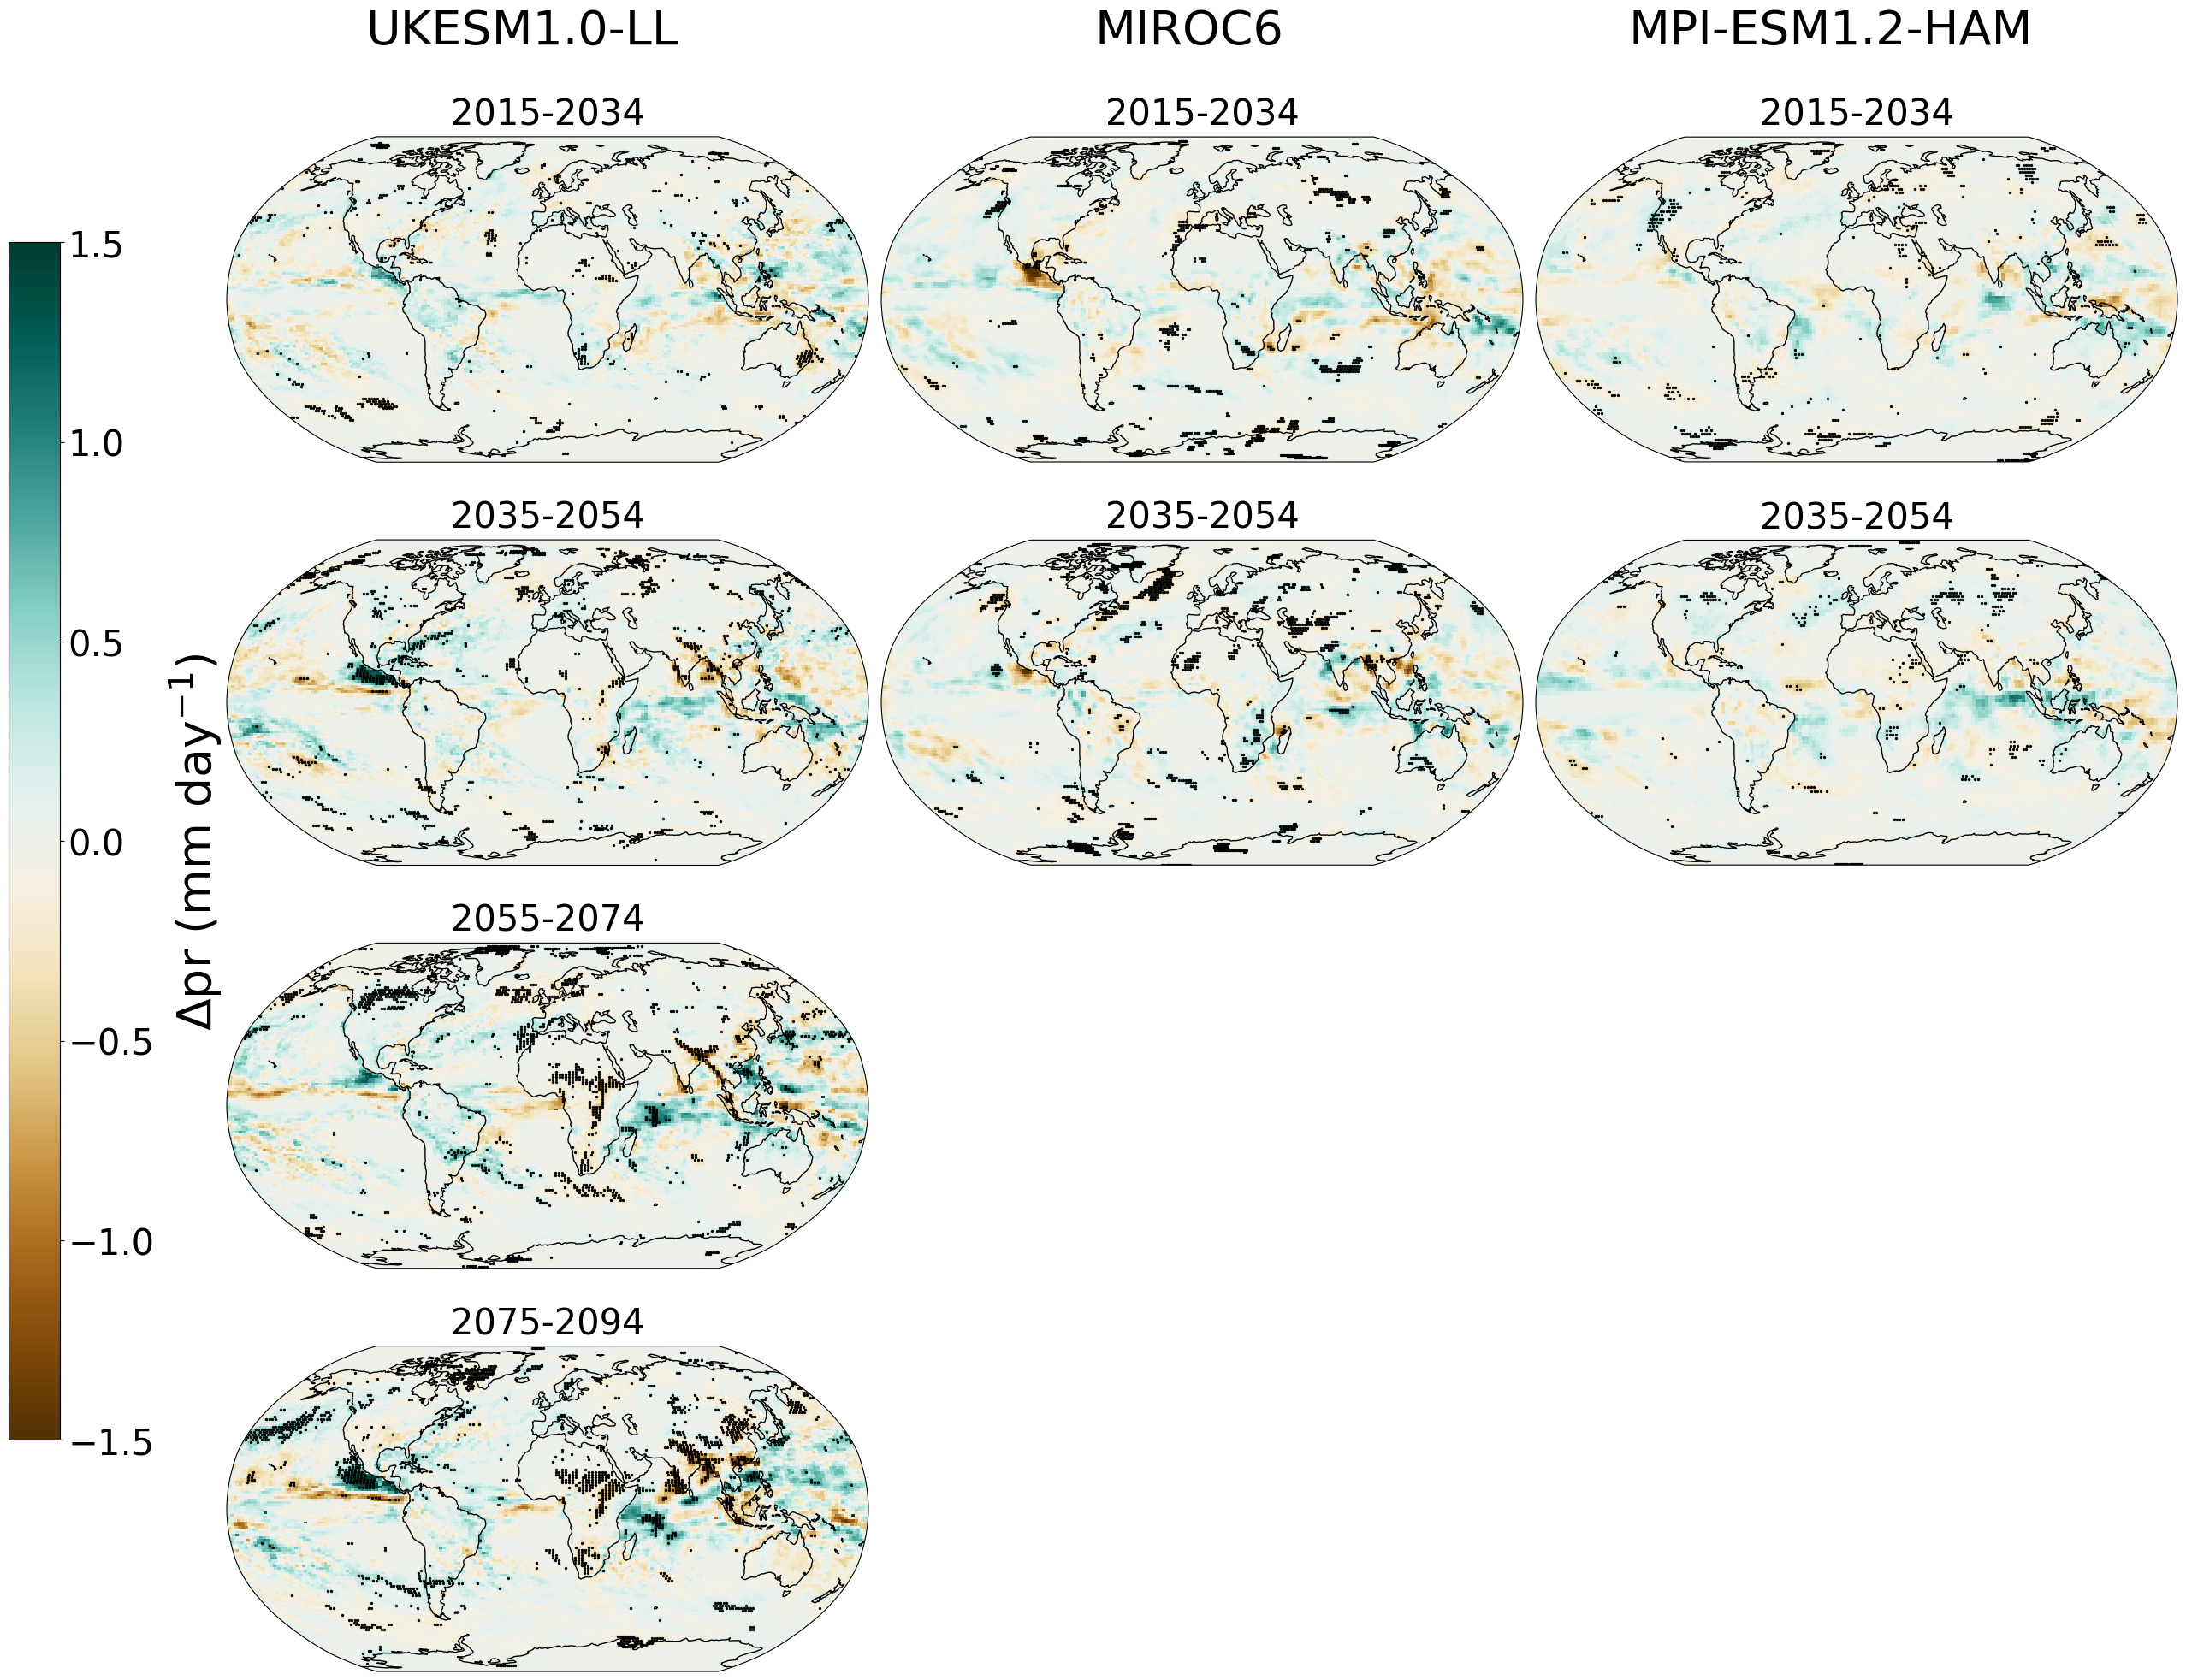

In [14]:
# Create the grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(30, 20), subplot_kw={'projection': ccrs.Robinson(central_longitude=0)})
axes = axes.T  # Transpose to get the desired column layout

# Function to plot data
def plot_data(ax, anomaly, title, ds_base, ds_signal, start_year, end_year):
    im = anomaly.plot(ax=ax, cmap=cmap_custom, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=30, pad=10)
    
    annual_means_base = calculate_annual_means(ds_base, start_year, end_year)
    annual_means_signal = calculate_annual_means(ds_signal, start_year, end_year)
    
    t_stat, p_value = ttest_ind(annual_means_base['pr'].values,
                                annual_means_signal['pr'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    lon, lat = np.meshgrid(annual_means_base['lon'].values, annual_means_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())
    
    return im

# Plotting for each model
last_im = None
for i, (start_year, end_year) in enumerate(UKESM_intervals):
    last_im = plot_data(axes[0, i], UKESM_anomalies_mm[i], f'{start_year}-{end_year}', UKESM_base, UKESM_signal, start_year, end_year)

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    last_im = plot_data(axes[1, i], MIROC6_anomalies_mm[i], f'{start_year}-{end_year}', MIROC_base, MIROC_signal, start_year, end_year)

for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    last_im = plot_data(axes[2, i], MPI_ESM_anomalies_mm[i], f'{start_year}-{end_year}', MPI_ESM_base, MPI_ESM_signal, start_year, end_year)

# Hide empty subplots for MIROC6 and MPI-ESM
for i in range(2, 4):
    fig.delaxes(axes[1, i])
    fig.delaxes(axes[2, i])

# Create the color bar with the last image
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label(r'$\Delta$pr (mm day$^{-1}$)', labelpad=10, fontsize=40)

    
# Add headers for each model
header_fontsize = 40
fig.text(0.25, 0.96, 'UKESM1.0-LL', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.51, 0.96, 'MIROC6', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.76, 0.96, 'MPI-ESM1.2-HAM', ha='center', va='bottom', fontsize=header_fontsize)

# Adjust layout
fig.tight_layout(rect=[0.13, 0, 0.9, 0.95])

plt.show()

# South and East Asia

### mm/day

/tmp/ipykernel_1691875/3910483870.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.11, 0, 0.9, 0.95])


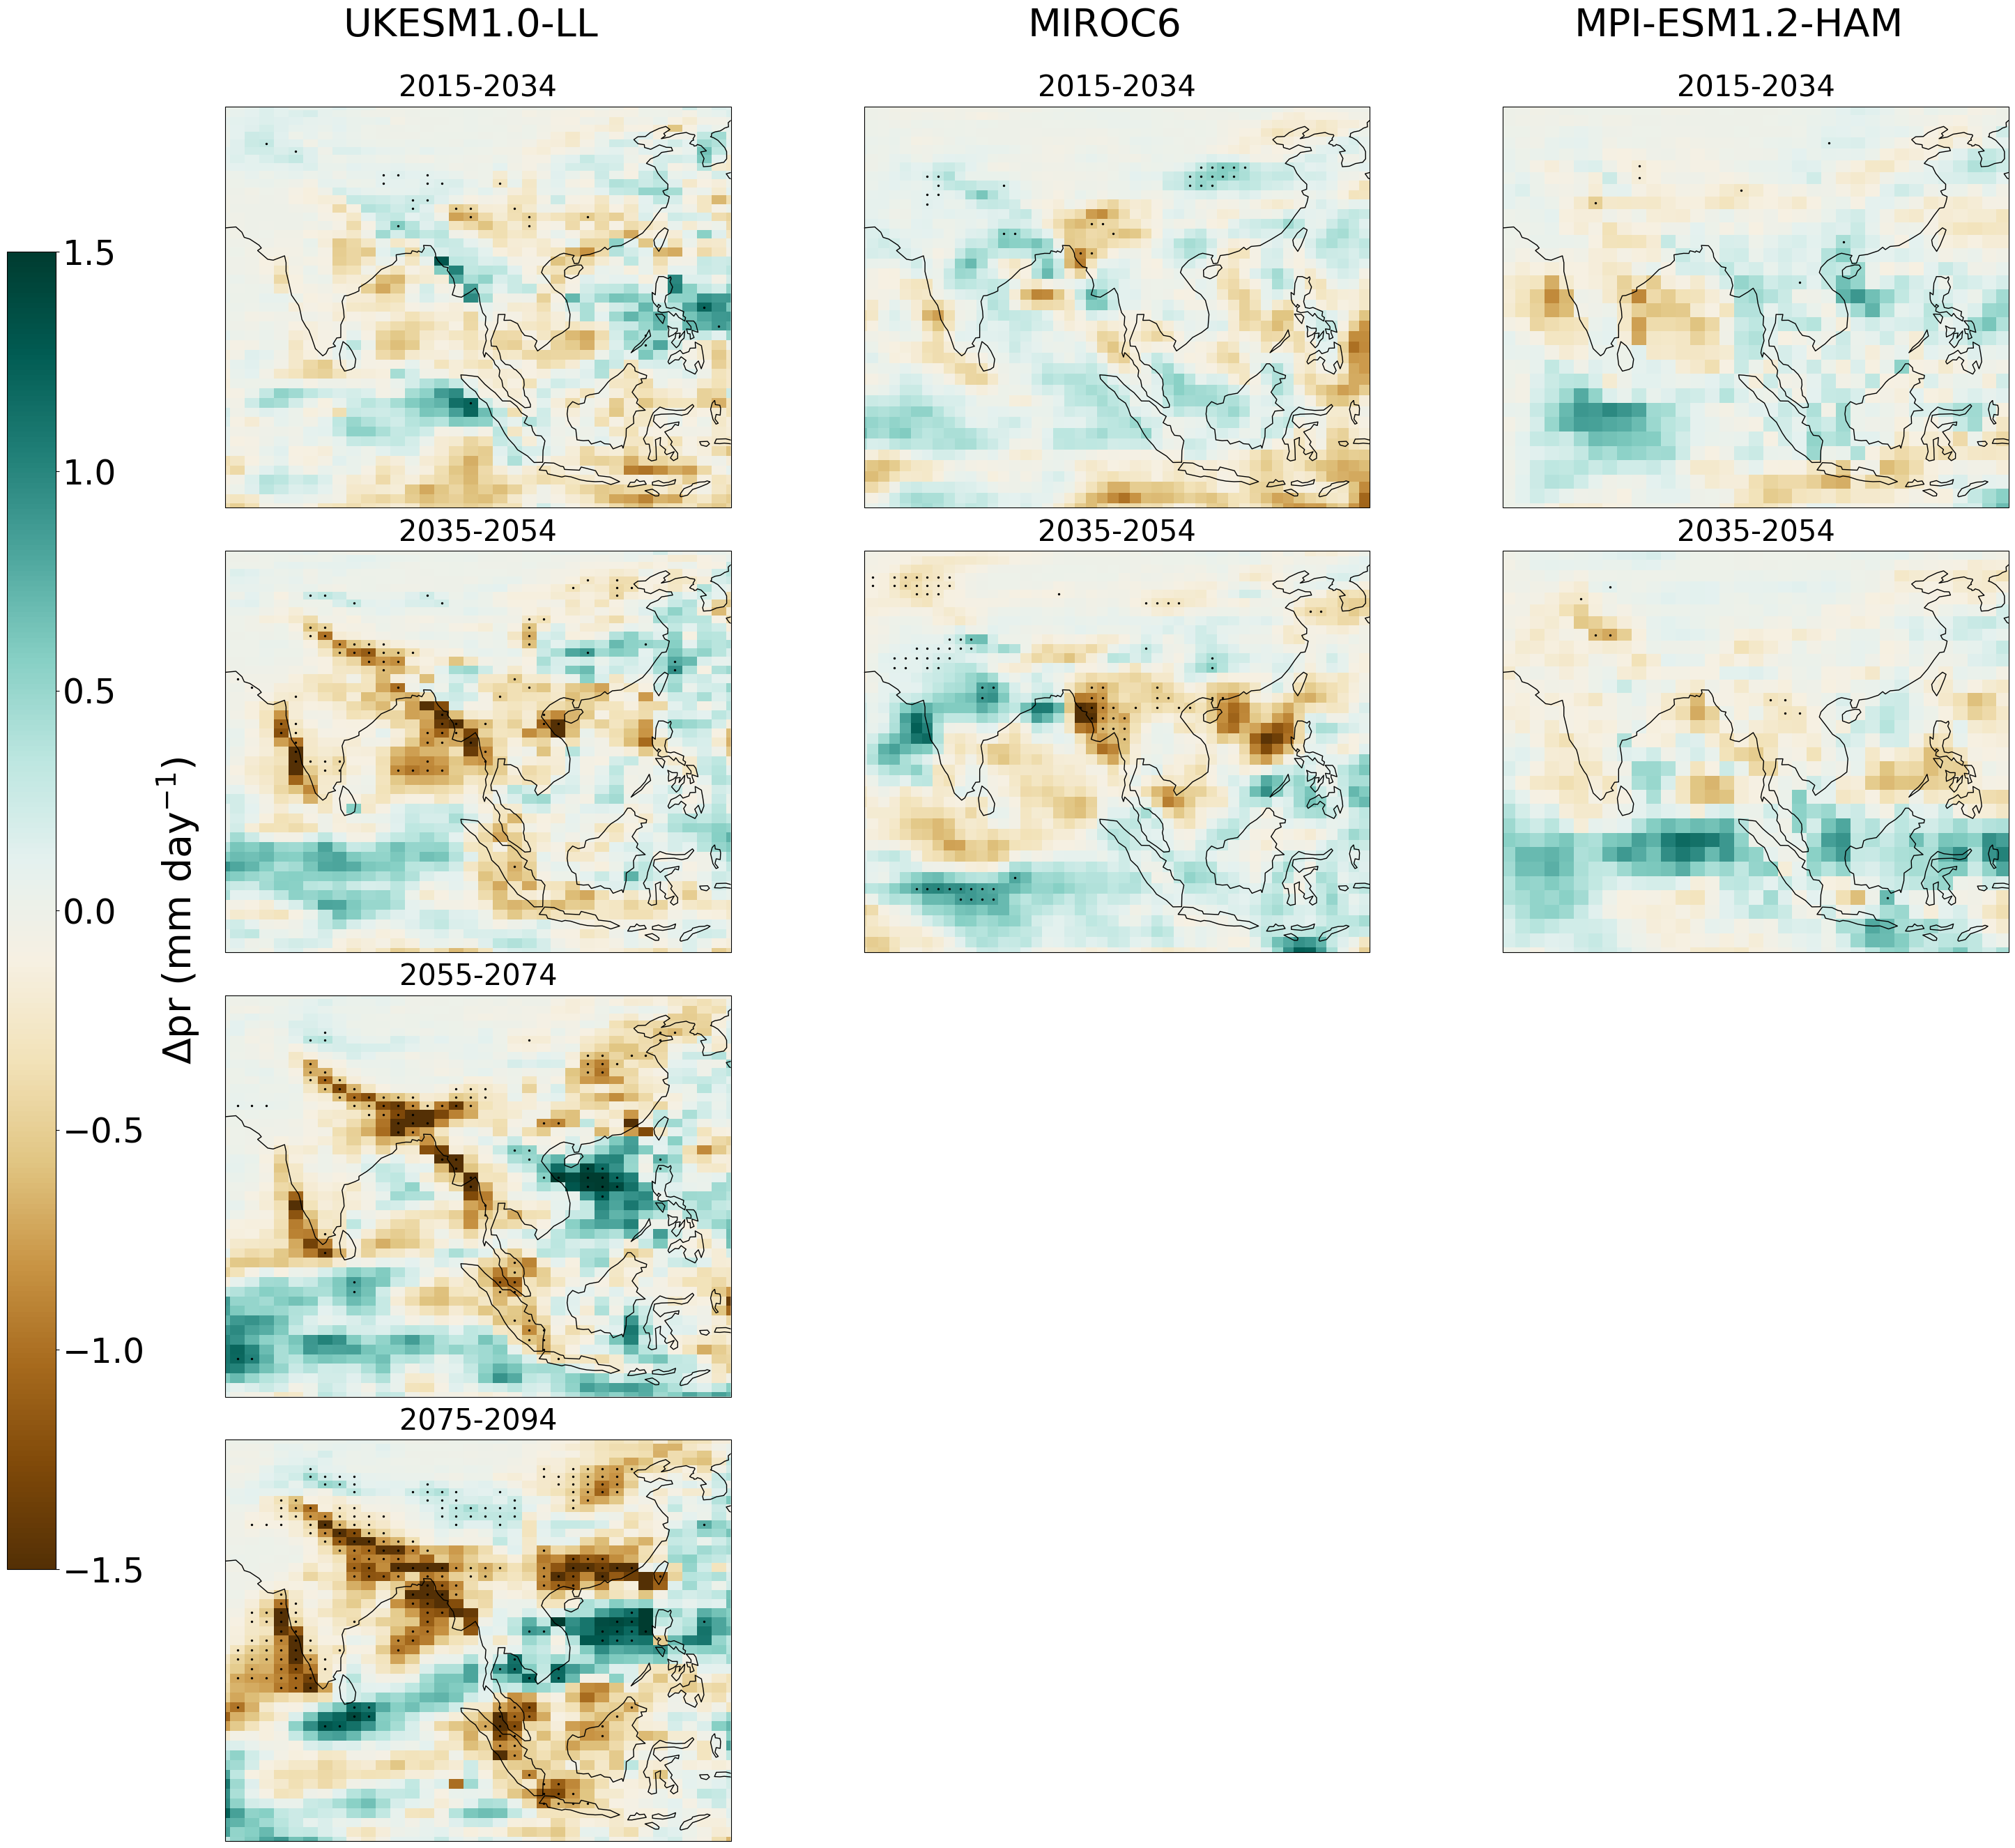

In [15]:
# Create the grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(35, 27), subplot_kw={'projection': ccrs.LambertCylindrical()})
axes = axes.T  # Transpose to get the desired column layout

# Function to plot data
def plot_data(ax, anomaly, title, ds_base, ds_signal, start_year, end_year):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap_custom, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=30, pad=10)
    
    annual_means_base = calculate_annual_means(ds_base, start_year, end_year)
    annual_means_signal = calculate_annual_means(ds_signal, start_year, end_year)
    
    # Select regional data for the t-test
    regional_base = annual_means_base.sel(lon=slice(65, 130), lat=slice(-10, 40))
    regional_signal = annual_means_signal.sel(lon=slice(65, 130), lat=slice(-10, 40))
    
    t_stat, p_value = ttest_ind(regional_base['pr'].values,
                                regional_signal['pr'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    lon, lat = np.meshgrid(regional_base['lon'].values, regional_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())
    
    return im

# Plotting for each model
last_im = None
for i, (start_year, end_year) in enumerate(UKESM_intervals):
    last_im = plot_data(axes[0, i], UKESM_anomalies_mm[i], f'{start_year}-{end_year}', UKESM_base, UKESM_signal, start_year, end_year)

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    last_im = plot_data(axes[1, i], MIROC6_anomalies_mm[i], f'{start_year}-{end_year}', MIROC_base, MIROC_signal, start_year, end_year)

for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    last_im = plot_data(axes[2, i], MPI_ESM_anomalies_mm[i], f'{start_year}-{end_year}', MPI_ESM_base, MPI_ESM_signal, start_year, end_year)

# Hide empty subplots for MIROC6 and MPI-ESM
for i in range(2, 4):
    fig.delaxes(axes[1, i])
    fig.delaxes(axes[2, i])

# Create the color bar with the last image
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=35)
    cbar.set_label(r'$\Delta$pr (mm day$^{-1}$)', labelpad=10, fontsize=40)
    
# Add headers for each model
header_fontsize = 40
fig.text(0.24, 0.96, 'UKESM1.0-LL', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.50, 0.96, 'MIROC6', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.76, 0.96, 'MPI-ESM1.2-HAM', ha='center', va='bottom', fontsize=header_fontsize)

# Adjust layout
fig.tight_layout(rect=[0.11, 0, 0.9, 0.95])

plt.show()

# Season

In [16]:
seasons = ['DJF', 'JJA']

## mm/day

### UKESM

/tmp/ipykernel_1691875/3029840855.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])


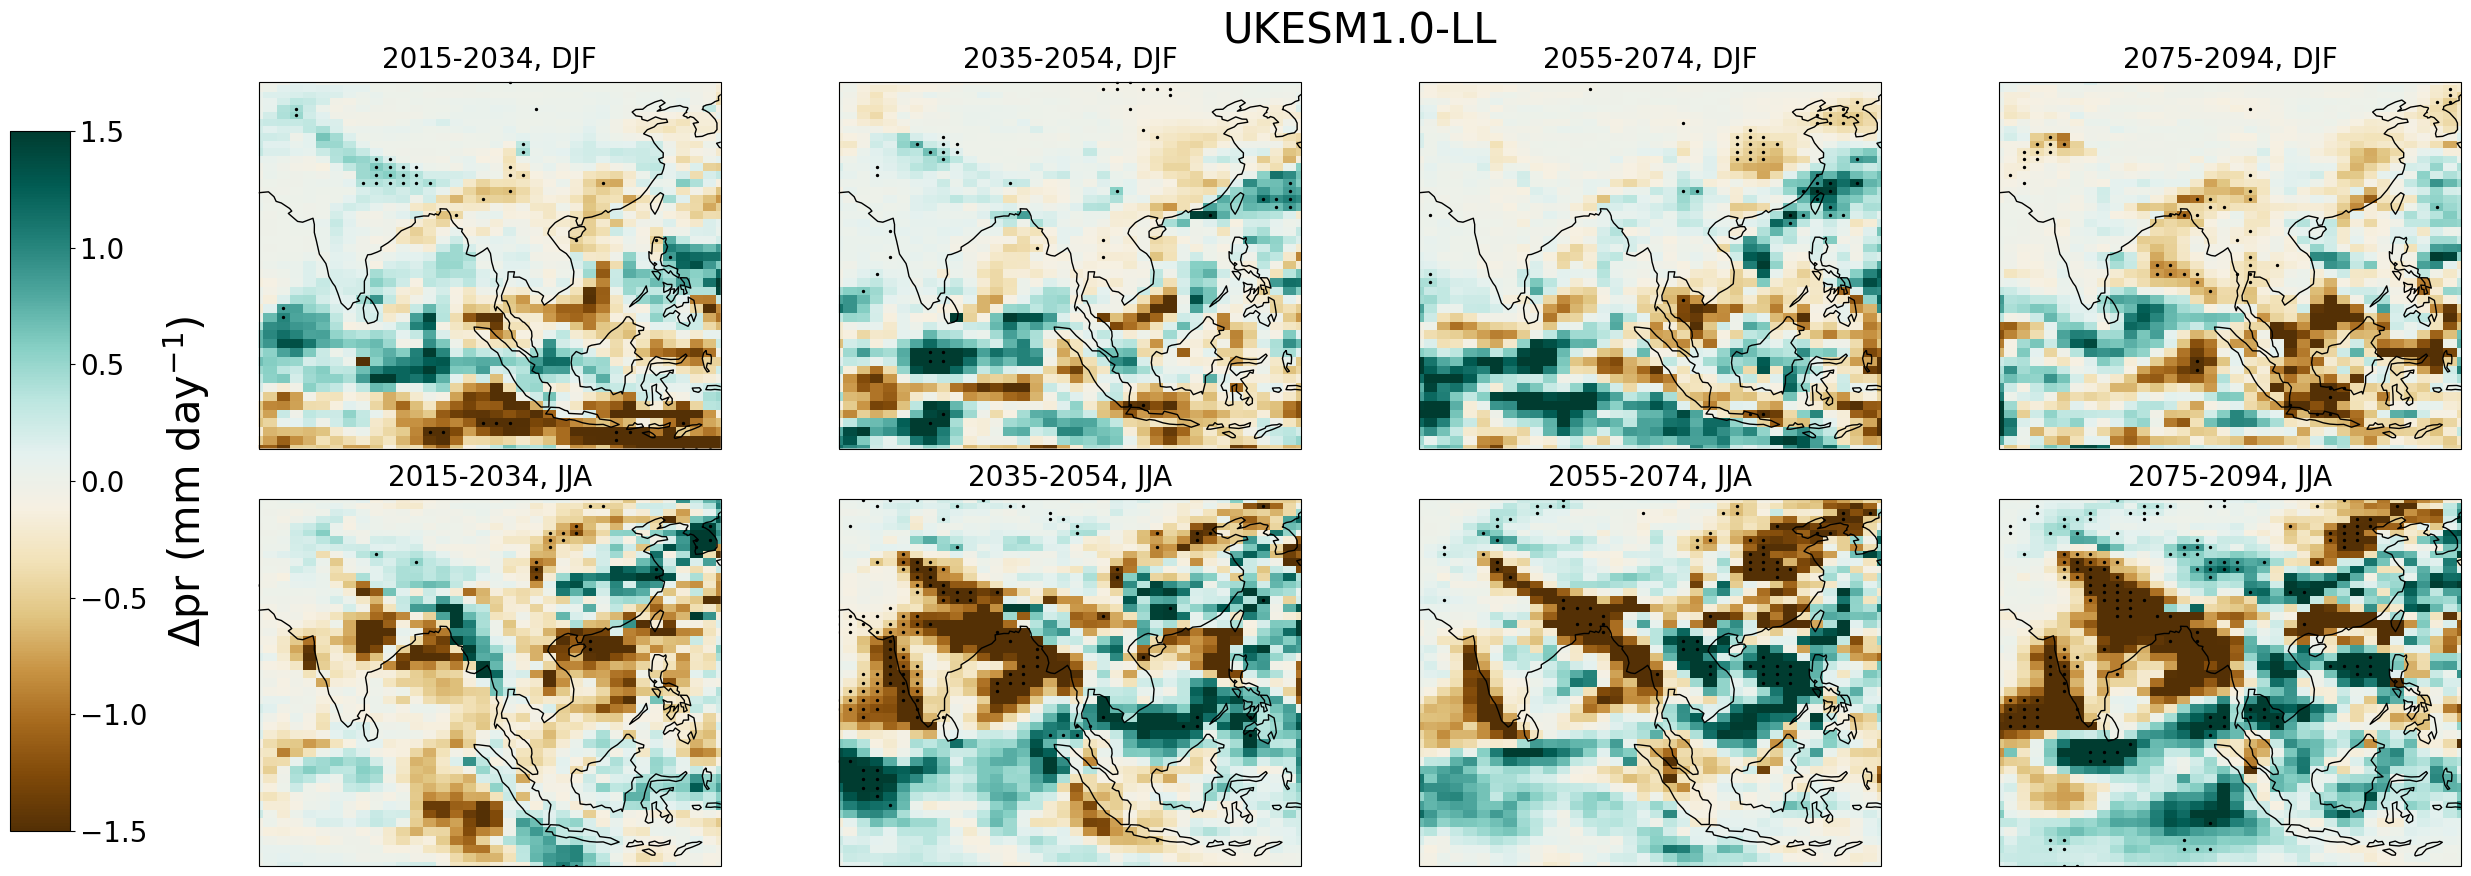

In [17]:
# Create the grid of subplots for UKESM with seasons in rows
fig, axes = plt.subplots(len(seasons), len(UKESM_intervals), figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})


def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap_custom, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform t-test
    t_stat, p_value = ttest_ind(seasonal_base['pr'].values,
                                seasonal_signal['pr'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

# Plotting for UKESM
last_im = None
for j, season in enumerate(seasons):
    for i, (start_year, end_year) in enumerate(UKESM_intervals):
        ax = axes[j, i]
        seasonal_base = UKESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = UKESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)

        # Calculate anomaly
        anomaly = calculate_seasonal_anomaly_mm(start_year, end_year, UKESM_base, UKESM_signal, season)

        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}',
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$pr (mm day$^{-1}$)', labelpad=10, fontsize=30)
    
fig.text(0.50, 0.95, 'UKESM1.0-LL', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])

plt.show()


## MIROC6 and MPI-ESM

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future 

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future 

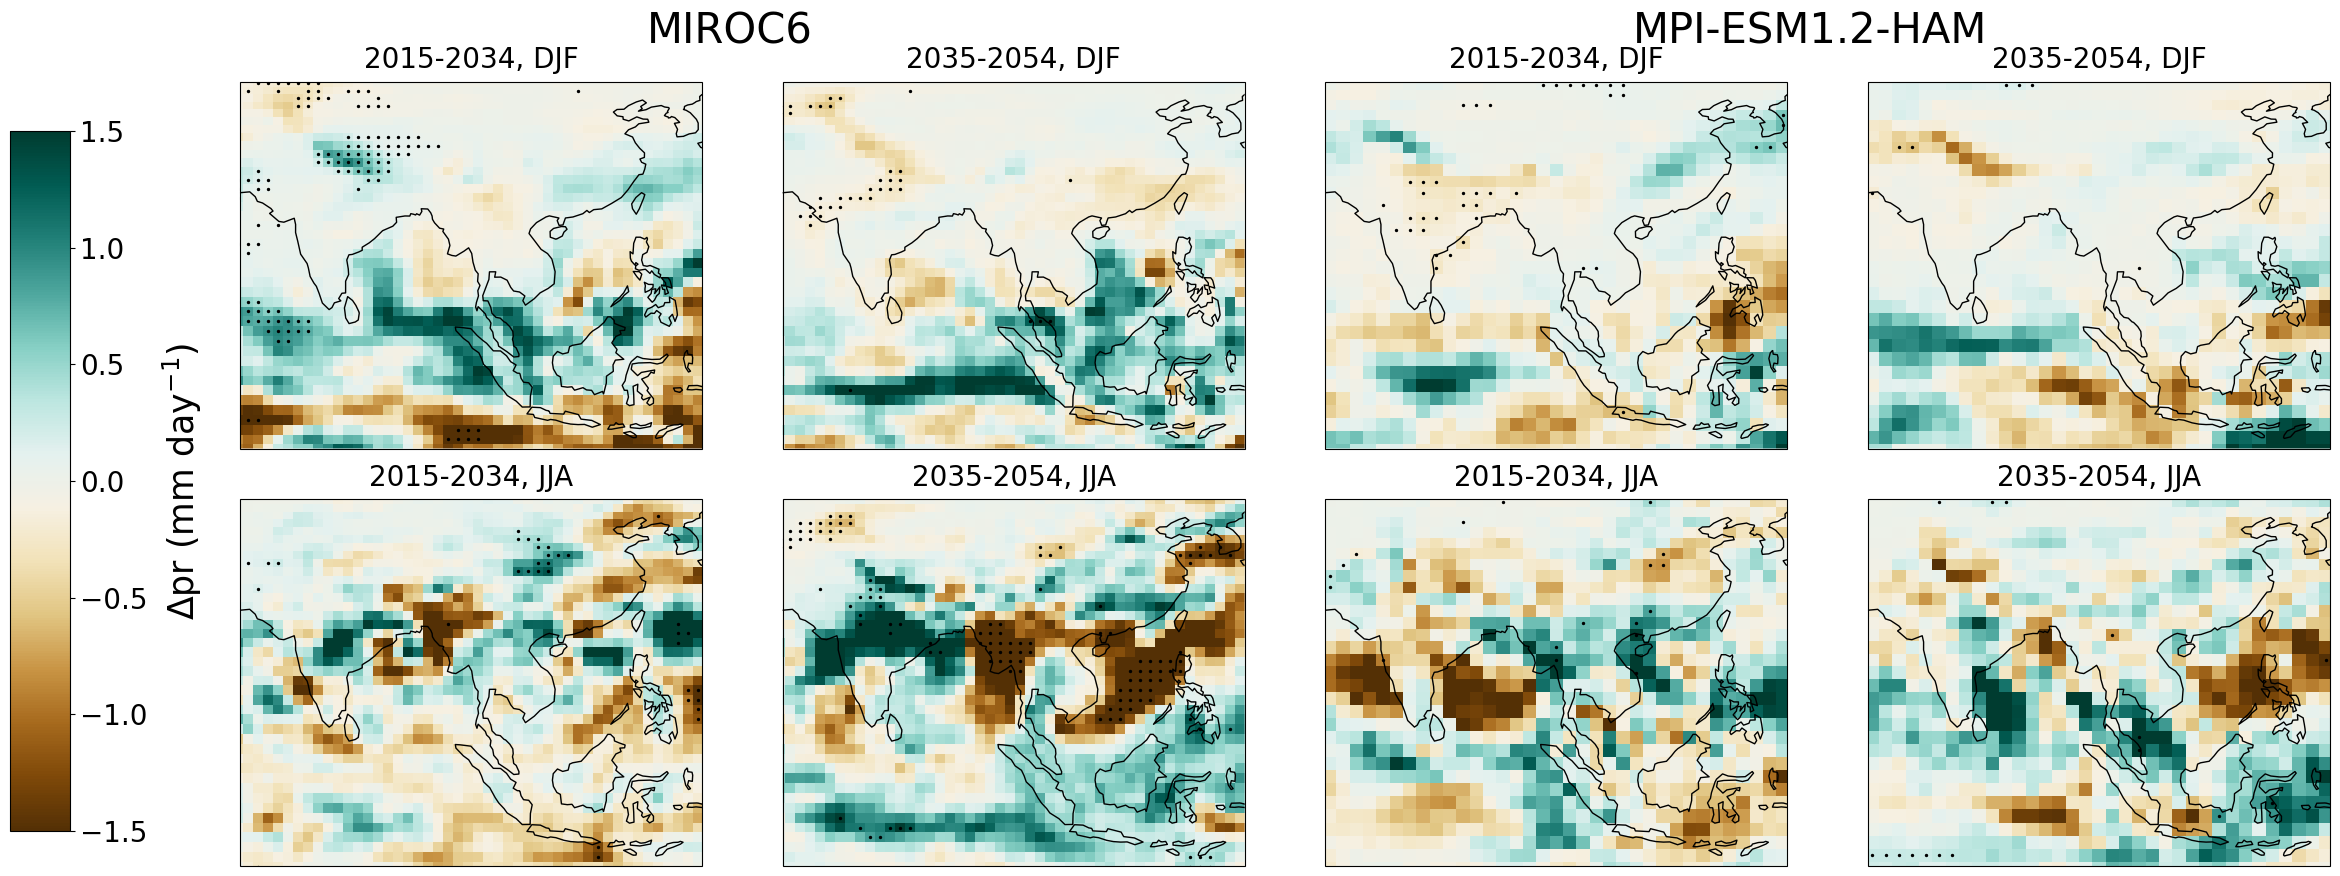

In [18]:
# Create the grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})

# Flatten axes for easier indexing
axes = axes.flatten()


def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap_custom, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform the t-test
    t_stat, p_value = ttest_ind(seasonal_base['pr'].values,
                                seasonal_signal['pr'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    # Overlay significant points
    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i]
        anomaly = calculate_seasonal_anomaly_mm(start_year, end_year, MIROC_base, MIROC_signal, season)
        seasonal_base = MIROC_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MIROC_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Loop through intervals and seasons for MPI-ESM
for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i + 2]  # Shift the index for MPI-ESM plots to the right
        anomaly = calculate_seasonal_anomaly_mm(start_year, end_year, MPI_ESM_base, MPI_ESM_signal, season)
        seasonal_base = MPI_ESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MPI_ESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.1, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$pr (mm day$^{-1}$)', labelpad=10, fontsize=25)
    
# Add headers for MIROC6 and MPI-ESM1.2-HAM
fig.text(0.34, 0.95, 'MIROC6', ha='center', va='center', fontsize=30)
fig.text(0.70, 0.95, 'MPI-ESM1.2-HAM', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.15, 0.1, 0.9, 0.95])

plt.show()

## %

### UKESM

/tmp/ipykernel_1691875/1893394453.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])


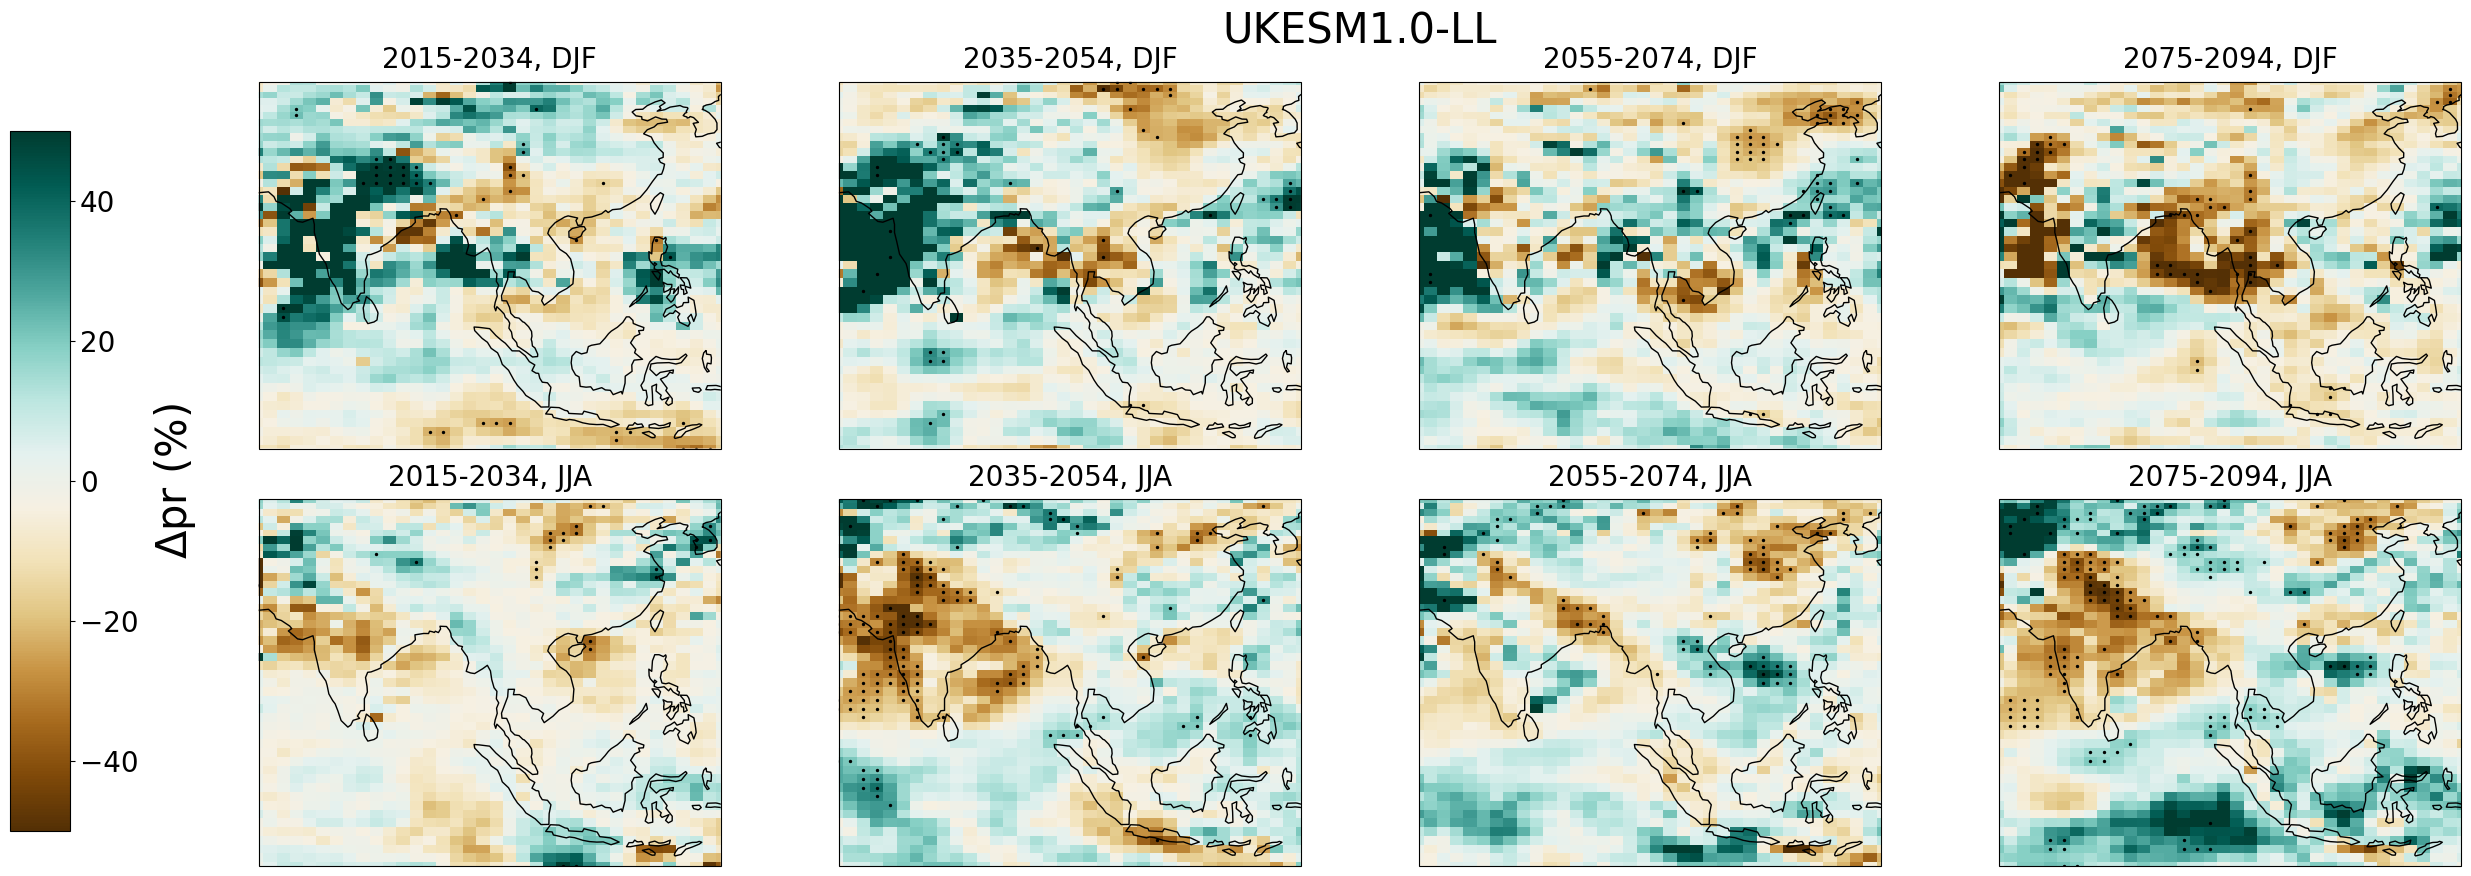

In [19]:
# Create the grid of subplots for UKESM with seasons in rows
fig, axes = plt.subplots(len(seasons), len(UKESM_intervals), figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})


def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap_custom, norm=norm_percent, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform t-test
    t_stat, p_value = ttest_ind(seasonal_base['pr'].values,
                                seasonal_signal['pr'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

# Plotting for UKESM
last_im = None
for j, season in enumerate(seasons):
    for i, (start_year, end_year) in enumerate(UKESM_intervals):
        ax = axes[j, i]
        seasonal_base = UKESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = UKESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)

        # Calculate anomaly
        anomaly = calculate_seasonal_anomaly_pr(start_year, end_year, UKESM_base, UKESM_signal, season)

        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}',
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$pr (%)', labelpad=10, fontsize=30)

fig.text(0.50, 0.95, 'UKESM1.0-LL', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])

plt.show()

### MIROC and MPI-ESM

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future 

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future 

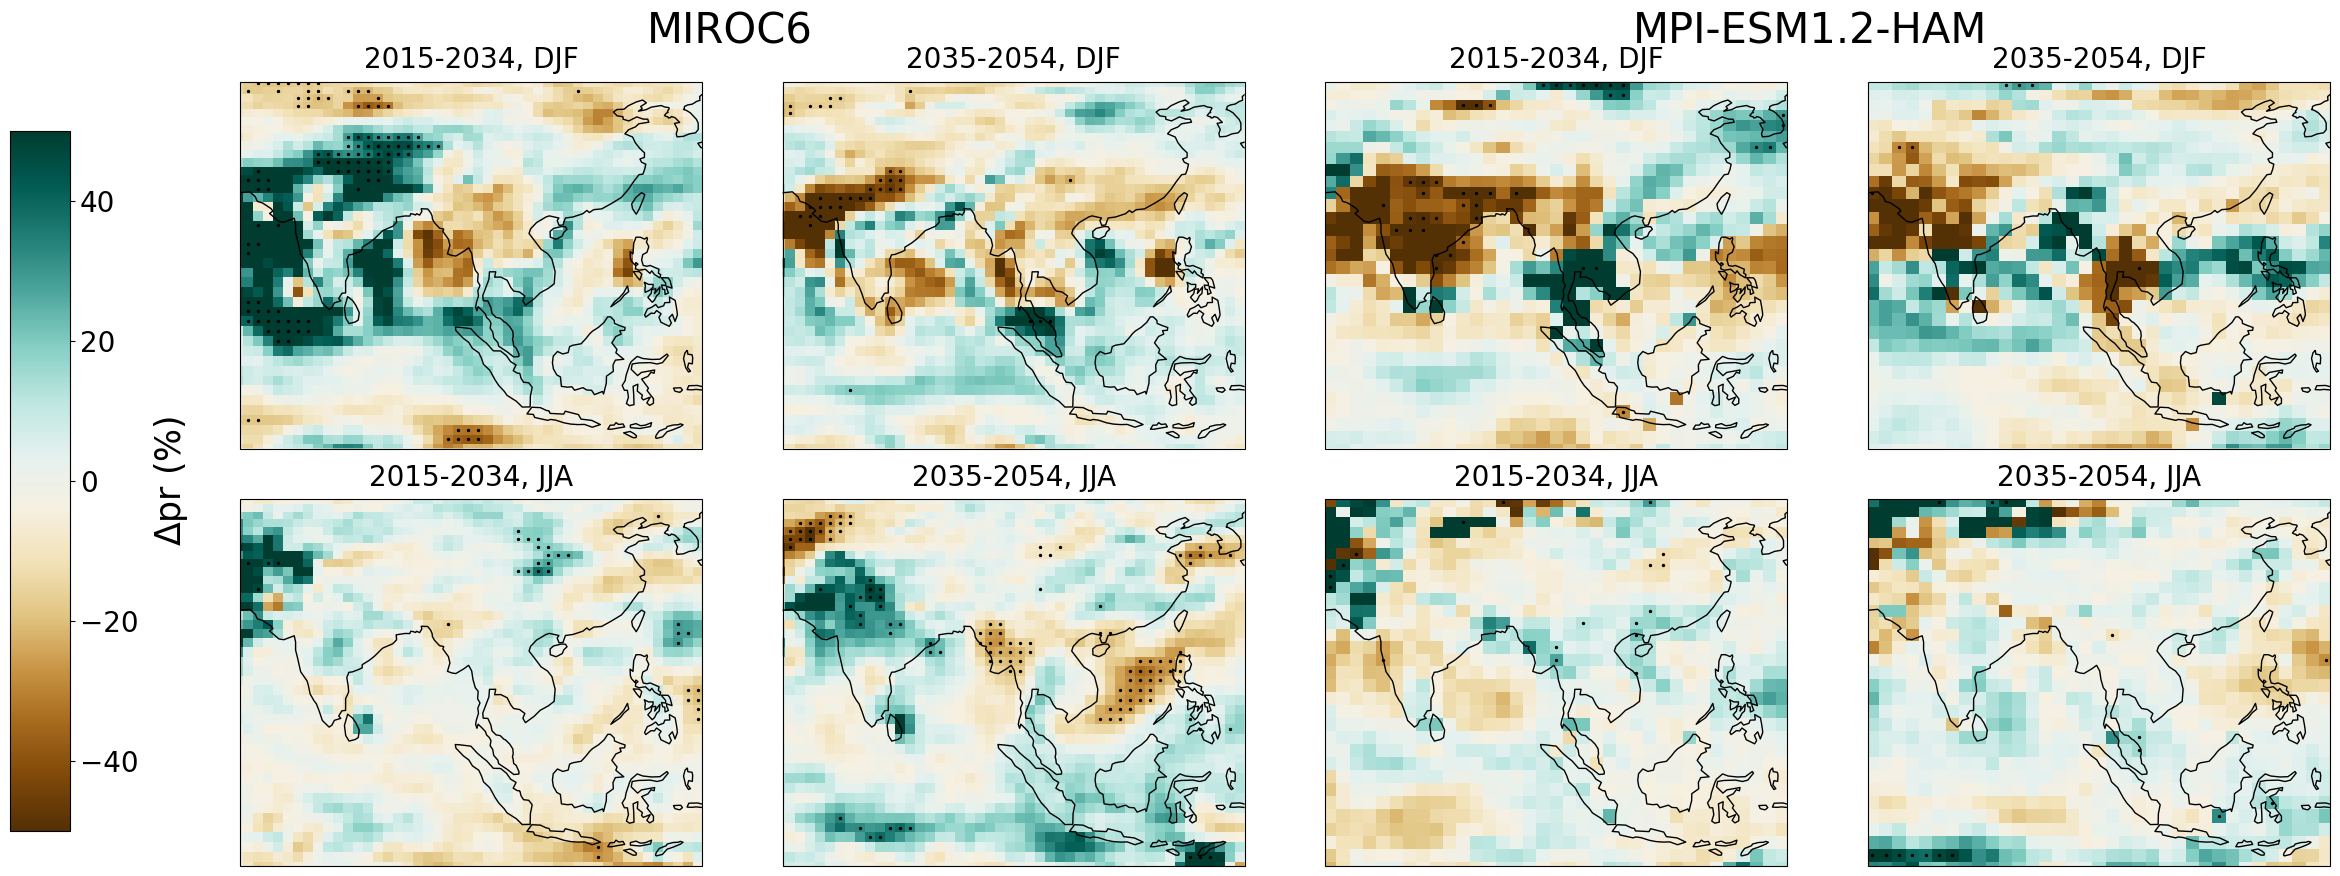

In [20]:
# Create the grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})

# Flatten axes for easier indexing
axes = axes.flatten()


def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap_custom, norm=norm_percent, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform the t-test
    t_stat, p_value = ttest_ind(seasonal_base['pr'].values,
                                seasonal_signal['pr'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    significant_points_mask = p_value < alpha

    # Overlay significant points
    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[significant_points_mask], lat[significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i]
        anomaly = calculate_seasonal_anomaly_pr(start_year, end_year, MIROC_base, MIROC_signal, season)
        seasonal_base = MIROC_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MIROC_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Loop through intervals and seasons for MPI-ESM
for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i + 2]  # Shift the index for MPI-ESM plots to the right
        anomaly = calculate_seasonal_anomaly_pr(start_year, end_year, MPI_ESM_base, MPI_ESM_signal, season)
        seasonal_base = MPI_ESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MPI_ESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.1, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$pr (%)', labelpad=10, fontsize=25)
    
# Add headers for MIROC6 and MPI-ESM1.2-HAM
fig.text(0.34, 0.95, 'MIROC6', ha='center', va='center', fontsize=30)
fig.text(0.70, 0.95, 'MPI-ESM1.2-HAM', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.15, 0.1, 0.9, 0.95])

plt.show()

In [21]:
norm_mean = mcolors.TwoSlopeNorm(vmin=-15, vcenter=0, vmax=15)

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future 

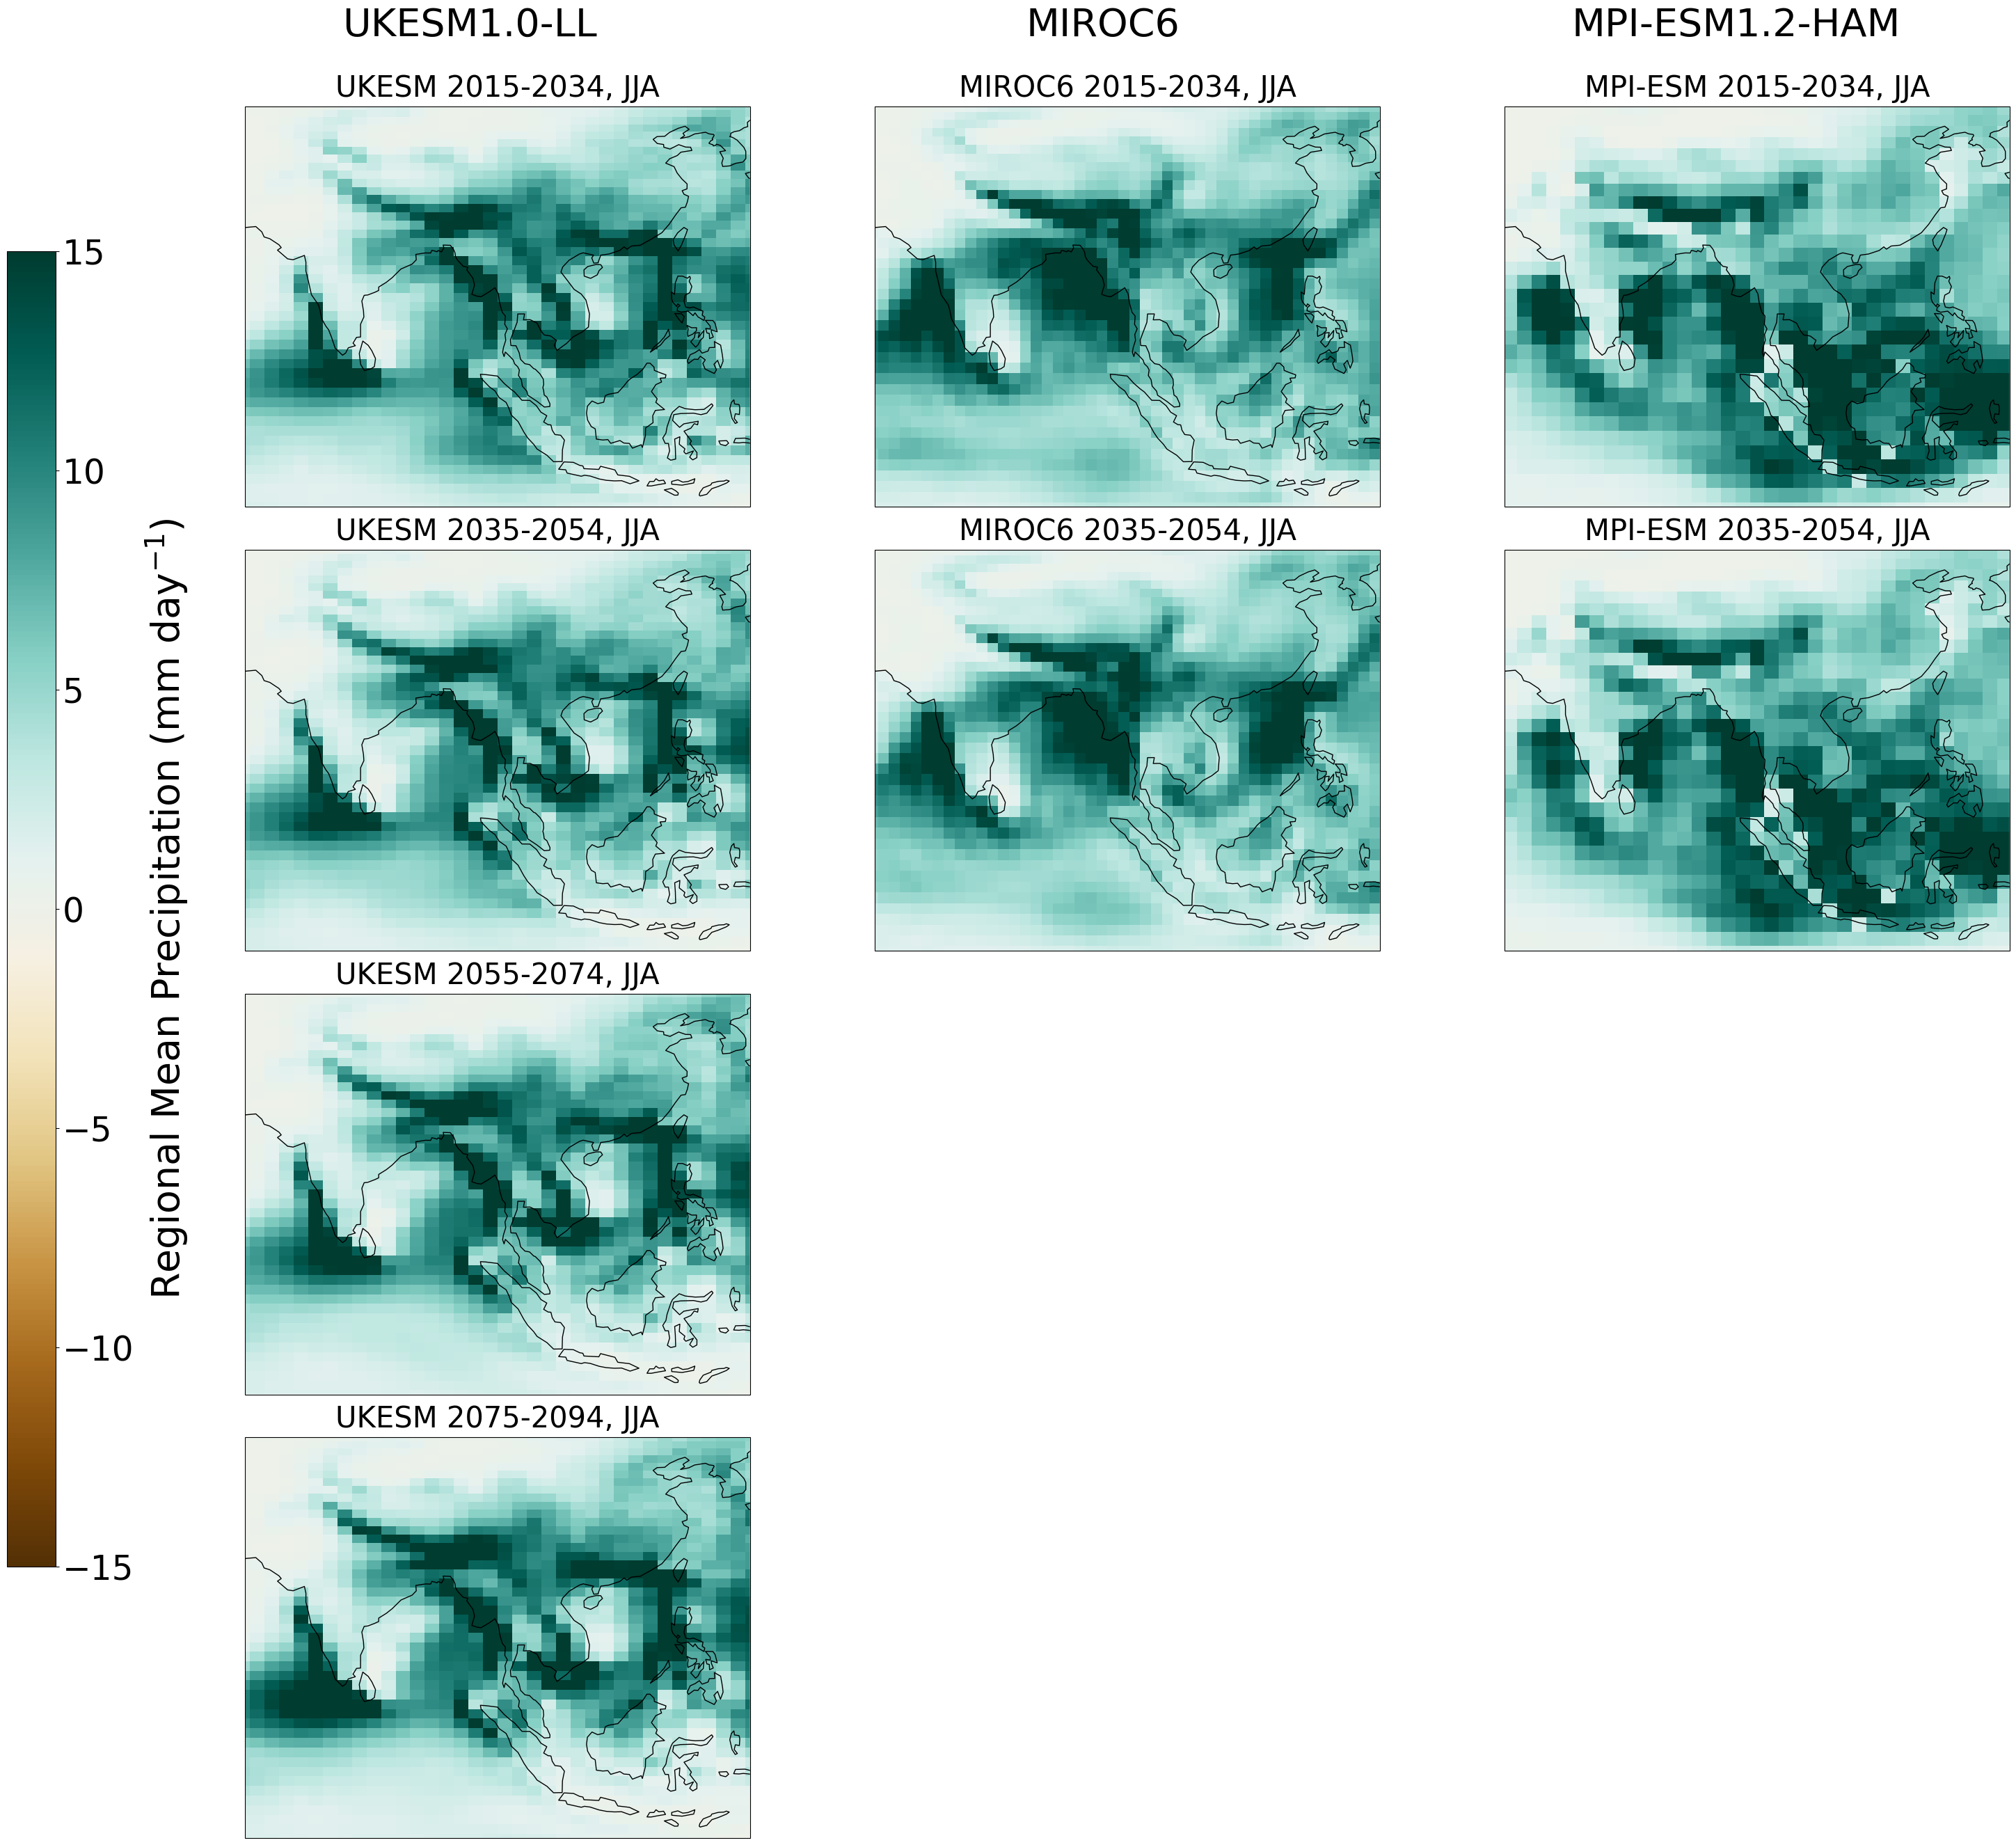

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(35, 27), subplot_kw={'projection': ccrs.LambertCylindrical()})
axes = axes.T  # Transpose to get the desired column layout

# Function to plot data
def plot_seasonal_data(ax, ds, interval, model_name, cmap, norm):
    # Filter data by JJA season and years
    seasonal_ds = ds.sel(time=slice(f"{interval[0]}-01-01", f"{interval[1]}-12-30"))
    seasonal_ds = seasonal_ds.sel(time=seasonal_ds['time'].dt.season == 'JJA')
    
    # Calculate the seasonal mean and plot
    seasonal_mean = seasonal_ds['pr'].mean(dim='time')
    im = seasonal_mean.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    
    # Set geographical extents for India and China
    ax.set_extent([65, 130, -10, 40])
    
    # Add coastlines and titles
    ax.coastlines()
    ax.set_title(f'{model_name} {interval[0]}-{interval[1]}, JJA', fontsize=30, pad=10)
    return im

last_im = None
for i, interval in enumerate(UKESM_intervals):
    last_im = plot_seasonal_data(axes[0, i], UKESM_base, interval, "UKESM", cmap_custom, norm_mean)

for i, interval in enumerate(MIROC6_intervals):
    last_im = plot_seasonal_data(axes[1, i], MIROC_base, interval, "MIROC6", cmap_custom, norm_mean)

for i, interval in enumerate(MPI_ESM_intervals):
    last_im = plot_seasonal_data(axes[2, i], MPI_ESM_base, interval, "MPI-ESM", cmap_custom, norm_mean)

# Hide unused axes
for i in range(len(MIROC6_intervals), 4):
    axes[1, i].set_visible(False)

for i in range(len(MPI_ESM_intervals), 4):
    axes[2, i].set_visible(False)

# Color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.set_label(r'Regional Mean Precipitation (mm day$^{-1}$)', labelpad=10, fontsize=40)
    cbar.ax.tick_params(labelsize=35)

# Add headers for each model
header_fontsize = 40
fig.text(0.24, 0.96, 'UKESM1.0-LL', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.50, 0.96, 'MIROC6', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.76, 0.96, 'MPI-ESM1.2-HAM', ha='center', va='bottom', fontsize=header_fontsize)

# Adjust layout
fig.tight_layout(rect=[0.12, 0, 0.9, 0.95])
plt.show()
